# Simulación de un fluido de dos fases mediante un método conservativo de curvas de nivel.

Queremos simular la interacción entre dos fluidos incompresibles, con distintas densidades y viscosidades. Para esto primero planteamos las ecuaciones de Navier-Stokes para flujo incompresible:

\begin{align}
\dfrac{D(\rho \mathbf{u})}{Dt} &= \nabla \cdot T + \mathbf{f}\\
\nabla \cdot \mathbf{u} &=0
\end{align}

Donde

$\rho$ es la densidad

$\mathbf{u}$ es el campo de velocidades

$\dfrac{D(\rho \mathbf{u})}{Dt} = \dfrac{\partial(\rho \mathbf{u})}{\partial t} + \mathbf{u}\cdot\nabla(\rho\mathbf{u})$ es su derivada material,

$T = -p\mathcal{I} + 2\mu D$ es el tensor de estrés,

$p$ es la presión del fluido,

$\mu$ es la viscosidad,

$D = \dfrac{1}{2} \left ( \nabla \mathbf{u} + \nabla \mathbf{u}^{T}\right )$ es el tensor de velocidad de deformación

$y \mathbf{f}$ es la suma de fuerzas dentro del fluido.

Como tenemos dos fluidos, no podemos asumir que la densidad y la viscosidad son constantes en todo el volumen. Para simular esto nos basaremos en el trabajo de [Olsson et al](https://www.ljll.math.upmc.fr/~hecht/ftp/Mireille-Haddad/A%20conservative%20level%20set%20method%20for%20two%20phase%20flow%20II__Olsson.pdf) y de [Michal Habera](https://www.researchgate.net/publication/281404445_Numerical_simulation_of_ferrofluids). La idea es tener una función escalón $\phi(x,t)$ que valga $1$ dentro de un fluido y $0$ en el otro. El borde entre ambos fluidos queda determinado por las curva de nivel $\phi = 0.5$. De allí que este es un método de curvas de nivel, o _Level set method_ en inglés. La idea básica es mover la interfaz entre los fluidos utilizando la ecuación de advección

\begin{equation}
\phi_t + \mathbf{u}\cdot\nabla\phi = 0, 
\end{equation}

y resolver las ecuaciones de Navier-Stokes usando 

$$\rho(x,t) = \rho_{1} + \phi(x,t)(\rho_{2}-\rho_{1})$$
$$\mu(x,t) = \mu_{1} + \mu(x,t)(\mu_{2}-\mu_{1})$$.

En la siguiente sección explico la manera de realizar el paso de advección numéricamente utilizando elementos finitos.

## Método conservativo de curvas de nivel


Supongamos que nos encontramos en una dimensión y tenemos una velocidad constante $v$ de fondo. Ignoramos por ahora las ecuaciones de Navier-Stokes. Definimos una función $\phi_0$ de la siguiente manera:


$$\phi_0(x) = \dfrac{1}{1+exp((|x|-0.5)/\epsilon)}\quad\textrm{en } x\in \Omega = [0,1)$$.

Denotaremos de ahora en más

$$V_{h} = \left\{f(x):f(x)\; \textrm{es lineal a trozos en } \Omega \textrm{ y } f(x) = 0 \;\forall x\in\partial\Omega_D\right\},$$ donde $\partial\Omega_{D}$ es la región de la frontera de $\Omega$ donde usaremos condiciones de contorno de Dirichlet.


In [1]:
from dolfin import *
from mshr import *
import matplotlib.pyplot as plt
mesh = UnitIntervalMesh(100)
ϵ = mesh.hmax()
Q = FunctionSpace(mesh, "Lagrange", 1)
ϕ_0 = Expression("1.0/(1.0+exp(-(x[0]-0.25)/eps))", eps = ϵ, degree = 2)
ϕ = project(ϕ_0, Q)
plot(ϕ)
parameters['reorder_dofs_serial'] = False

$\epsilon$ es el ancho de la interfaz numérica entre los fluidos, y es aproximadamente igual al ancho de grilla $\Delta x$.

Discretizamos ahora en el tiempo la ecuación de advección utilizando el método de Crank-Nicolson

$$\dfrac{\phi^{n+1}-\phi^{n}}{dt} = v\dfrac{\phi^{n+1}_x + \phi^{n}_x}{2},$$

y luego escribimos la forma variacional del problema asumiendo condiciones de contorno de Neumann

$$\int_{0}^{1} \dfrac{\phi^{n+1}-\phi^{n}}{dt}qdx = \int_{0}^{1}v \dfrac{\phi^{n+1}+\phi^{n}}{2} \dfrac{\partial q}{\partial x} dx - v\left(\dfrac{\phi^{n+1}+\phi^{n}}{2}\right)q\biggr |^{1}_{0}\quad\forall q \in V_h.$$ 

En casos bidimensionales la velocidad será usualmente $0$ en el borde, por lo que el último término no será necesario.

Mostramos ahora un ejemplo de esta implementación:

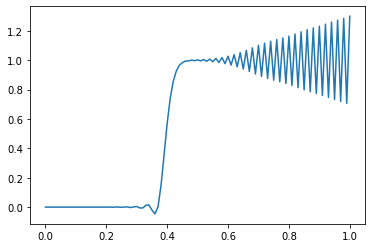

In [2]:
#Velocidad de fondo:
v = Constant(1.0)
#Δt = Δx
dt = mesh.hmax()


Q = FunctionSpace(mesh, "Lagrange", 1)
ϕ_0 = Expression("1.0/(1.0+exp(-(x[0]-0.25)/eps))", eps = ϵ, degree = 2)


#definimos funciones
ϕ = TrialFunction(Q)
q = TestFunction(Q)
ϕ_n = Function(Q)
ϕ_np = Function(Q)
ϕ_n.interpolate(ϕ_0)


#Definición del problema variacional
a_ϕ1 = ϕ*q*dx - 0.5*dt*(ϕ*q.dx(0)*v)*dx + 0.5*ϕ*q*ds
L_ϕ1 = ϕ_n*q*dx + 0.5*dt*(ϕ_n*q.dx(0)*v)*dx + 0.5*ϕ_n*q*ds


#hacemos algunos pasos temporales
for m in range(15):
    solve(a_ϕ1 == L_ϕ1, ϕ_np)  #advección, neumann bcs
    ϕ_n.assign(ϕ_np) 
    # Update current time
    t = dt*m
#x=Q.tabulate_dof_coordinates()
plot(ϕ_n)

Inmediatamente nos hemos encontrado con un problema: Tras solo unos pocos pasos temporales aparecen oscilaciones espurias en la región de la interfaz y en la frontera. Más aún, como la ecuación de advección lo único que hace es mover la solución, estos errores numéricos se propagan sin disiparse. La solución al problema es agregar un término disipativo a la ecuación de advección,

$$\phi_t + v \phi_x = \dfrac{1}{\eta}\left ( \epsilon \phi_{xx} - (\phi(1-\phi))_{x}\right ),$$

donde $\eta$ es un término que depende de la velocidad $v$ y $\hat{n} = \phi_x/|\phi_x|$ indica la dirección normal de la interfaz entre los fluidos. Notar que esta ecuación es no lineal y que el término derecho de la ecuación es nulo para $\phi_0$. Para resolver esta ecuación numéricamente la dividimos en dos partes: primero un paso de advección para obtener un $\phi^{n}_{*}$ tentativo,


\begin{equation}
\phi_t + v\phi_{x} = 0,
\end{equation}


y luego un paso de reinicialización

$$\phi_t = \dfrac{1}{\eta}\left ( \epsilon \phi_{xx} - (\phi(1-\phi))_{x}\right ).$$

En lugar de buscar un $\eta$ hacemos un cambio de variables $\tau = t/\eta$, $dt = d\tau$ y resolvemos 

$$\phi_\tau =  \epsilon \phi_{xx} - (\phi(1-\phi))_{x}$$

hasta alcanzar una solución de equilibrio.

En resumen, primero hacemos un paso de advección para obtener un $\phi_{*}^{n+1}$ tentativo, y luego un paso de reinicialización en una sub-escala temporal que disipa errores numéricos sin modificar los perfiles de la forma $1/(1+exp(-x/\epsilon))$. Nuevamente discretizaremos temporalmente la ecuación con Crank-Nicolson y usamos una forma linearizada de la formulación variacional:


$$
        \int_\Omega q\dfrac{\phi_{c}^{k+1}-\phi_{c}^{k}}{d\tau}dx - \int_\Omega\left\{\left(\dfrac{\phi_{c}^{k+1}+\phi_{c}^{k}}{2}- \phi_{c}^{k+1}\phi_{c}^{k}\right) - \epsilon\left(\dfrac{\phi_{c}^{k+1}+\phi_{c}^{k}}{2}\right)_{x}\right\}\dfrac{\partial q}{\partial x}dx = 0 \quad \forall q \in V_h,
$$

donde comenzamos con $k=0$ y $\phi_{c}^{0} = \phi_{*}^{n+1}$ e iteramos hasta llegar a la condición

$$\dfrac{\|\phi_{c}^{m+1}-\phi_{c}^{m}\|}{d\tau} \lt \delta$$
para alguna tolerancia $\delta$.


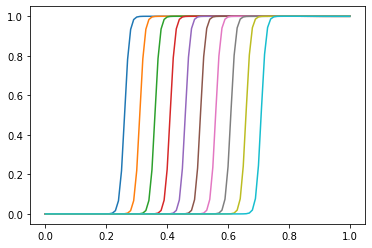

In [3]:
#Velocidad de fondo:
v = Constant(1.0)
#Δt \sim Δx
d = 0.1
h = mesh.hmax()
ϵ = h**(1-d)*0.5 # Valor para ϵ recomendado en varias referencias
dt = h

ϕ_0 = Expression("1.0/(1.0+exp(-(x[0]-0.25)/eps))", eps = ϵ, degree = 2)

#definimos funciones
ϕ = TrialFunction(Q)
q = TestFunction(Q)
ϕ_n = Function(Q)
ϕ_k = Function(Q)
ϕ_np = Function(Q)
ϕ_n.interpolate(ϕ_0)

#Definición del problema variacional
a_ϕ1 = ϕ*q*dx - 0.5*dt*(ϕ*q.dx(0)*v)*dx + 0.5*ϕ*q*ds
L_ϕ1 = ϕ_n*q*dx + 0.5*dt*(ϕ_n*q.dx(0)*v)*dx + 0.5*ϕ_n*q*ds

dτ = dt

#reinicialización
a_ϕ2 = ϕ*q*dx - dτ*(ϕ*(0.5-ϕ_k) - ϵ*0.5*ϕ.dx(0))*q.dx(0)*dx
L_ϕ2 = ϕ_k*q*dx + dτ*(0.5*ϕ_k - ϵ*0.5*ϕ_k.dx(0))*q.dx(0)*dx

F_ϕ2 = 1/dτ*(ϕ_np-ϕ_k)*q*dx - 0.5*(ϕ_np+ϕ_k)*(1-0.5*(ϕ_np+ϕ_k))*q.dx(0)*dx + 0.5*ϵ*(ϕ_np.dx(0)+ϕ_k.dx(0))*q.dx(0)*dx

#hacemos algunos pasos temporales
for m in range(50):
    solve(a_ϕ1 == L_ϕ1, ϕ_np)  #advección
    # Update current time
    t = dt*m
    k = 0
    err = 1.0
    tol = 1e-8
    #"""
    while (k < 100 and err > tol):
        ϕ_k.assign(ϕ_np)
        solve(a_ϕ2 == L_ϕ2, ϕ_np)  #forma lineal
        #solve(F_ϕ2 == 0, ϕ_np)    #forma no lineal
        diff = ϕ_np-ϕ_k
        err = assemble(diff**2*dx(mesh))/dτ
        k = k+1
    #print(err, k)
    #"""
    ϕ_n.assign(ϕ_np) 
    if m%5 == 0:
        #ploteamos a distintos tiempos
        plot(ϕ_n)


## Paso a más dimensiones


Ya sabemos cómo es la fórmula para advección en más de una dimensión. Veamos la reinicialización. En principio la fórmula es

$$\phi_\tau = \epsilon \nabla\cdot\nabla\phi - \nabla(\phi(1-\phi))\cdot\hat{n}$$

donde $\hat{n} = \nabla\phi/|\nabla\phi|$. Debido a problemas de difusión tangencial en la interfaz, utilizaremos


$$\phi_\tau = \epsilon \nabla\cdot((\nabla\phi\cdot\hat{n})\hat{n}) - \nabla(\phi(1-\phi))\cdot\hat{n}$$.


La formulación variacional es

$$
q\int_\Omega \dfrac{\phi_{c}^{k+1}-\phi_{c}^{k}}{d\tau}dx - \int_\Omega\left\{\left(\dfrac{\phi_{c}^{k+1}+\phi_{c}^{k}}{2}- \phi_{c}^{k+1}\phi_{c}^{k}\right) - \epsilon\nabla\left(\dfrac{\phi_{c}^{k+1}+\phi_{c}^{k}}{2}\right)\cdot\hat{n}\right\}(\nabla q\cdot\hat{n})dx = 0 \quad \forall q \in V_h,
$$

Notar que $\hat{n}$ se mantiene fijo durante todas las iteraciones de la reinicialización, es decir, $\hat{n} = \nabla\phi^{n+1}_{*}/|\nabla\phi^{n+1}_{*}|$. A su vez, proyectaremos a $\hat{n}$ sobre un espacio de elementos finitos $W_{h}$ de grado 2 y dimensión 2.

$$\int_\Omega \hat{n}\cdot{v} dx= \int_\Omega \dfrac{\nabla\phi^{n+1}_{*}}{|\nabla\phi^{n+1}_{*}|}\cdot vdx \quad \forall v\in W_{h}$$


A continuación mostramos un ejemplo típico de advección en un vórtice bidimensional.

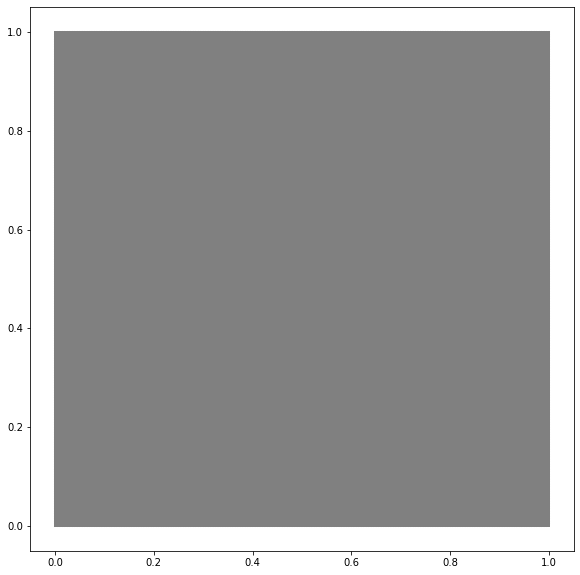

In [67]:
#Ejemplo de advección en un vórtice

#We start by loading some stuff
import matplotlib.pyplot as plt
import numpy as np
from dolfin import *
from mshr import *

# Print log messages only from the root process in parallel
parameters["std_out_all_processes"] = False;

#=========================== Mesh Creation ========================#
mesh = UnitSquareMesh(200,200)
plt.figure(figsize = (10,10))
plot(mesh)

In [68]:
#some definitions:
h = mesh.hmax()
dt = (h**1.1)*0.5
ϵ = h**0.9*0.5
dτ = dt

In [69]:
# Define function spaces (P2-P1)
V = VectorFunctionSpace(mesh, "Lagrange", 2)
Q = FunctionSpace(mesh, "Lagrange", 1)

# Define trial and test functions
ϕ = TrialFunction(Q)
q = TestFunction(Q)

# Define functions for solutions at previous and current time steps

u_n = Function(V, name = "Fluid Velocity")
n = Function(V, name = "Normal")
g = Function(V, name = "gradient")
δ = Function(Q, name = "δ")
ϕ_n = Function(Q, name = "phi")
ϕ_k = Function(Q, name = "phi")
ϕ_np  = Function(Q, name = "phi")

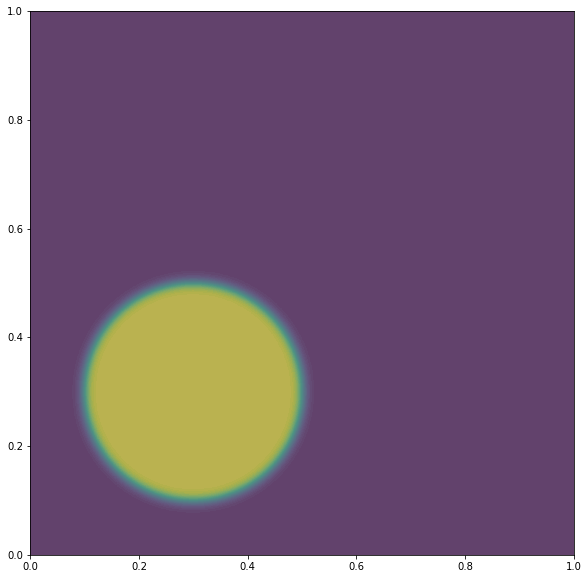

In [70]:
#Definimos el campo ϕ_0

R = 0.2
x_c = 0.3
y_c = 0.3
d = 0.1
ϵ = h**(1-d)*0.5
dτ = h**(1+d)*0.5
ϕ_0 = Expression("1.0/(1.0 + exp((sqrt((x[0]-xc)*(x[0]-xc)+(x[1]-yc)*(x[1]-yc)) - R)/eps))", degree = 2, eps = ϵ, R = R, xc = x_c, yc = y_c)
ϕ_n.interpolate(ϕ_0)
ϕ_k.assign(ϕ_n)
ϕ_np.assign(ϕ_n)
g.assign(project(grad(ϕ_n), V))
δ.assign(project(sqrt(inner(g,g)), Q))
n.assign(project(g/δ, V))


plt.figure(figsize = (10,10))
plot(ϕ_n)
plot(mesh, alpha = 0.5)

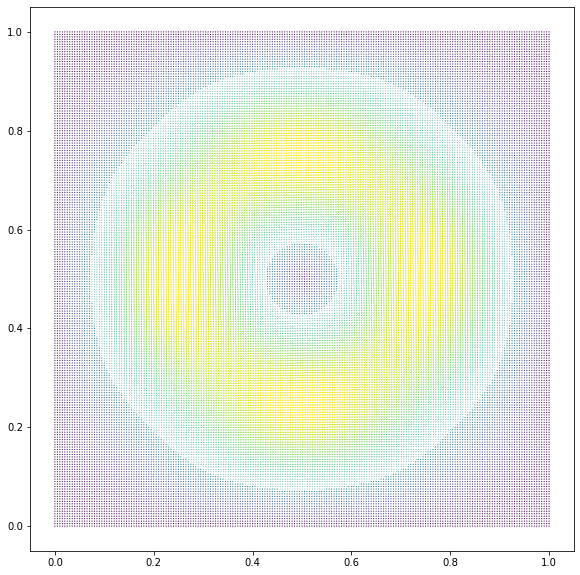

In [71]:
import sympy as sp

#Campo de Velocidades

x, y= sp.symbols('x[0] x[1]')
r = sp.sqrt((x-0.5)*(x-0.5) + (y-0.5)*(y-0.5))

rstr = sp.printing.ccode(r)

uϕstr = f"({rstr} < 0.25 ? 4 : ({rstr} < 0.5 ? 2/{rstr} -4: 0.0))"

u0 = Expression(("sin(pi*x[0])*sin(pi*x[0])*(sin(2*pi*x[1]))", f"-sin(pi*x[1])*sin(pi*x[1])*(sin(2*pi*x[0]))"), degree = 2)
u_n.interpolate(u0)
plt.figure(figsize = (10,10))
#u_n.assign(-u_n)
plot(u_n)

In [72]:
#Open file
phifile = File("advection_bubble/phi-vortex-test-hres-2-.pvd")

### Esta parte que sigue toma su tiempo...

In [73]:
#====================================Advection====================================#

# Time-stepping
num_steps = 600
t = 0

#paso de adveción (notar que asumimos que u = 0 en el borde y por ende no necesitamos integrales para ϕ allí.)
a_ϕ1 = ϕ*q*dx - 0.5*dt*(ϕ*inner(grad(q), u_n))*dx 
L_ϕ1 = ϕ_n*q*dx + 0.5*dt*(ϕ_n*inner(grad(q), u_n))*dx

#Reinicialización
a_ϕ2 = ϕ*q*dx - dτ*(ϕ*(0.5-ϕ_k) - ϵ*0.5*inner(grad(ϕ),n))*inner(grad(q), n)*dx
L_ϕ2 = ϕ_k*q*dx + dτ*(0.5*ϕ_k - 0.5*ϵ*inner(grad(ϕ_k),n))*inner(grad(q), n)*dx

F_ϕ2 = 1/dτ*(ϕ_np-ϕ_k)*q*dx - 0.5*(ϕ_np+ϕ_k)*(1-0.5*(ϕ_np+ϕ_k))*inner(n, grad(q))*dx + 0.5*ϵ*inner(n, grad(ϕ_np+ϕ_k))*inner(n, grad(q))*dx

areas = []
tiempos = []
for m in range(int(num_steps/2)):
    print(t)
    # Save to file
    if (m%10==0): 
        phifile << (ϕ_n, t)
        print("data saved...")
    #Hacemos paso de advección
    solve(a_ϕ1 == L_ϕ1, ϕ_np)  #neumann bcs
    
    #Calculamos \hat{n}
    g.assign(project(grad(ϕ_np), V))
    δ.assign(project(sqrt(inner(g,g)), Q))
    n.assign(project(g/sqrt(inner(g,g)), V))
    #Hacemos la reinicialización
    k = 0
    err = 1.0
    tol = 1e-7
    while (k < 100 and err > tol):
        ϕ_k.assign(ϕ_np)
        #solve(F_ϕ2 == 0, ϕ_np) #Forma no lineal
        solve(a_ϕ2 == L_ϕ2, ϕ_np) #Forma lineal
        diff = ϕ_np-ϕ_k
        err = assemble(diff**2*dx(mesh))/dτ
        k = k+1
    print(err, k)
    ϕ_n.assign(ϕ_np)
    areas.append(assemble(ϕ_n*dx(mesh)))
    # Update current time
    t = dt*m
    tiempos.append(t)


u_n.assign(-u_n)  #reverse velocity  

for m in range(int(num_steps/2), num_steps):
    print(t)
    # Save to file
    if (m%10==0): 
        phifile << (ϕ_n, t)
        print("data saved...")
    #Hacemos paso de advección
    solve(a_ϕ1 == L_ϕ1, ϕ_np)  #neumann bcs
    
    #Calculamos \hat{n}
    g.assign(project(grad(ϕ_np), V))
    δ.assign(project(sqrt(inner(g,g)), Q))
    n.assign(project(g/sqrt(inner(g,g)), V))
    #Hacemos la reinicialización
    k = 0
    err = 1.0
    tol = 1e-7
    while (k < 100 and err > tol):
        ϕ_k.assign(ϕ_np)
        #solve(F_ϕ2 == 0, ϕ_np) #Forma no lineal
        solve(a_ϕ2 == L_ϕ2, ϕ_np) #Forma lineal
        diff = ϕ_np-ϕ_k
        err = assemble(diff**2*dx(mesh))/dτ
        k = k+1
    print(err, k)
    ϕ_n.assign(ϕ_np)
    areas.append(assemble(ϕ_n*dx(mesh)))
    # Update current time
    t = dt*m
    tiempos.append(t)


0
data saved...
9.686980094201465e-08 17
0.0
7.925740332377904e-08 5
0.002154782832136988
7.838566512819771e-08 6
0.004309565664273976
8.544625526711993e-08 6
0.0064643484964109635
9.124069822343727e-08 6
0.008619131328547951
9.491052341154787e-08 6
0.01077391416068494
9.703655643917442e-08 6
0.012928696992821927
9.82158032897876e-08 6
0.015083479824958914
9.884917256181702e-08 6
0.017238262657095903
9.917553514423819e-08 6
0.01939304548923289
data saved...
9.933061504049164e-08 6
0.02154782832136988
9.939008463745183e-08 6
0.023702611153506865
9.939586332691888e-08 6
0.025857393985643854
9.937120455273256e-08 6
0.028012176817780843
9.932918097429298e-08 6
0.030166959649917828
9.927724131139191e-08 6
0.03232174248205482
9.921975958997684e-08 6
0.034476525314191805
9.915936097403718e-08 6
0.03663130814632879
9.90977249333343e-08 6
0.03878609097846578
9.903624522307779e-08 6
0.04094087381060277
data saved...
9.897610914097623e-08 6
0.04309565664273976
9.891814686925999e-08 6
0.0452504394

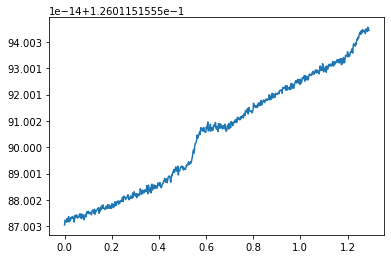

In [74]:


np.save("areas-test-hres-2-.npy",np.array([tiempos, areas]))
plt.plot(tiempos, areas)

## Regresando a las ecuaciones de Navier-Stokes

### Tensión Superficial

Una de las fuerzas principales que actuarán sobre los dos fluidos es la tensión superficial. Tenemos dos formas básicas de expresarla:

Usando la curvatura de la interfaz,

$$\mathbf{f}_{st} = \sigma\kappa\nabla\phi = -\sigma\nabla\cdot\hat{n}\nabla\phi$$

O como la divergencia de un tensor,

\begin{align*}
T_{st} &= \sigma(\mathcal{I} - \hat{n}\otimes\hat{n})\delta\\
\mathbf{f}_{st} &= \nabla\cdot T_{st}
\end{align*}

Nos centraremos en esta segunda forma pues es más fácil de integrar y no requiere tomar derivadas segundas.

### Splitting Method

La forma más fácil de resolver las ecuaciones de Navier-Stokes en elementos finitos es usando los llamados _splitting methods_. 

Primero avanzamos tentativamente unicamente el campo de velocidades $\mathbf{u}^{n+1}_{*}$ sin modificar la presión:
\begin{align}
\dfrac{1}{\Delta t}\left ( \rho^{n+1}\mathbf{u}_{*}^{n+1} - \rho^n\mathbf{u}^{n}\right) + \nabla\cdot\left(\rho^{n+1}\mathbf{u}^n\otimes\mathbf{u}_{*}^{n+1} \right ) = -\nabla p^{n}\\
+\dfrac{1}{Re}\nabla\cdot\left (\mu^{n+1}\left(\nabla\mathbf{u}_{*}^{n+1} + (\nabla\mathbf{u}^{n})^T \right ) \right )\\
+ \dfrac{1}{We}\nabla\cdot T_{st}^{n+1} + \dfrac{\rho^{n+1}}{Fr^{2}}\mathbf{e}_g
\end{align}

Notar que hemos normalizado las ecuaciones. Los últimos dos términos corresponden a la tensión superficial y a la fuerza gravitatoria. Esto nos da un campo de velocidades tentativo cuya divergencia no necesariamente es 0. Luego restamos la ecuación anterior la misma ecuación pero con $p^{n+1}$ en lugar de $p^{n}$ y usando $u^{n+1}$ en lugar de $u^{n+1}_{*}$; usando el hecho de que $\nabla\cdot u^{n+1}$ llegamos a

\begin{align}
\dfrac{1}{\Delta t}\nabla\cdot\mathbf{u}_{*}^{n+1} = \nabla\cdot\left ( \dfrac{\nabla(p^{n+1}-p^{n})}{\rho^{n+1}}\right).
\end{align}

De esta forma actualizamos la presión. Finalmente, calculamos la velocidad $u^{n+1}$ usando

$$\mathbf{u}^{n+1} = \mathbf{u}_{*}^{n+1} - \dfrac{\Delta t}{\rho^{n+1}}\nabla(p^{n+1}-p^{n}).$$

### Formulación Variacional


Velocidad tentativa:
\begin{align*}
\dfrac{1}{\Delta t}\int_{\Omega}\left ( \rho^{n+1}\mathbf{u}_{*}^{n+1} - \rho^{n}\mathbf{u}^{n}\right ) \cdot \mathbf{v} d\mathbf{x} +\int_{\partial\Omega} \rho^{n+1}(\mathbf{u}^{n}\cdot\mathbf{n}_{\partial\Omega})(\mathbf{u}_{*}^{n+1}\cdot\mathbf{v})dS - \int_{\Omega}(\mathbf{u}^{n}\cdot\nabla\mathbf{v})\cdot(\rho^{n+1}\mathbf{u}_{*}^{n+1}) = \\
-\int_{\partial\Omega}(p^{n}\mathbf{v})\cdot\mathbf{n}_{\partial\Omega}dS + \int_\Omega p^{n}\nabla\cdot\mathbf{v}d\mathbf{x} + \dfrac{1}{Re}\int_{\partial\Omega}\mu^{n+1}\left(\left(\nabla\mathbf{u}_{*}^{n+1} + (\nabla\mathbf{u}^{n})^T)\right)\cdot\mathbf{v}\right)\cdot\mathbf{n}_{\partial\Omega}dS \\
- \dfrac{1}{Re}\int_{\Omega}\left(\nabla\mathbf{u}_{*}^{n+1} + (\nabla\mathbf{u}^{n})^T)\right)\cdot\nabla\mathbf{v}d\mathbf{x} + \int_{\Omega}\left ( \dfrac{1}{We} T^{n+1}_{st}\cdot\nabla\mathbf{v} + \dfrac{1}{Fr^{2}}\rho^{n+1}\mathbf{e}_{g}\right ) \cdot\mathbf{v}d\mathbf{x}
\end{align*}
Actualización de la presión:

\begin{align*}
\dfrac{1}{\Delta t}\int_{\Omega}q\nabla\cdot\mathbf{u}_{*}^{n+1} = \int_{\partial\Omega}q\left[\dfrac{\nabla(p^{n+1}-p^{n})}{\rho^{n+1}}\right]\cdot\mathbf{n}_{\partial\Omega}dS - \int_{\Omega}\left[\dfrac{\nabla(p^{n+1}-p^{n})}{\rho^{n+1}}\right]\cdot\nabla q d\mathbf{x}
\end{align*}

Aquí debemos imponer $\nabla(p^{n+1}-p^{n})\cdot\mathbf{n}_{\partial\Omega} = 0$, lo cual elimina el término de superficie. Esta es una condición de contorno no física que deriva del método de proyección y debe ser usada aunque puede reducir la precisión del método.

Finalmente, actualizamos el campo de velocidades con 

\begin{align*}
\mathbf{u}^{n+1}\cdot\mathbf{v}d\mathbf{x} = \int_{\Omega} \mathbf{u}_{*}^{n+1}\cdot\mathbf{v}d\mathbf{x}-\Delta t\int_{\Omega}\left[\dfrac{\nabla(p^{n+1}-p^{n})}{\rho^{n+1}}\right]\cdot\mathbf{v} d\mathbf{x}.
\end{align*}

A continuación presento código para simular algunos ejemplos, como una gota oscilando, una gota callendo, o una burbuja subiendo. Notar que el código es bastante sensible a los valores que uno use de viscosidad y es complicado hacerlo andar bien; puse algunos ejemplos que vi que funcionaban.

In [ ]:


%matplotlib inline
import matplotlib.pyplot as plt
from dolfin import *
from mshr import *

# Print log messages only from the root process in parallel
parameters["std_out_all_processes"] = False;

We set the evolution parameters:

In [ ]:
#some cases:

oscilation = False
rising = True
drop = False
damm = False

In [3]:
# Set parameter values
#dt = 0.005
#T = 3.0 #3
#nu = 0.01

T = 2.0
num_steps = 4000
mod = 20

dt = T/num_steps

#num_steps = 200
#mod = 1


Re = 1.0
μ = 1.0
   
ρ = 1.0

Create the meshes and plot them:

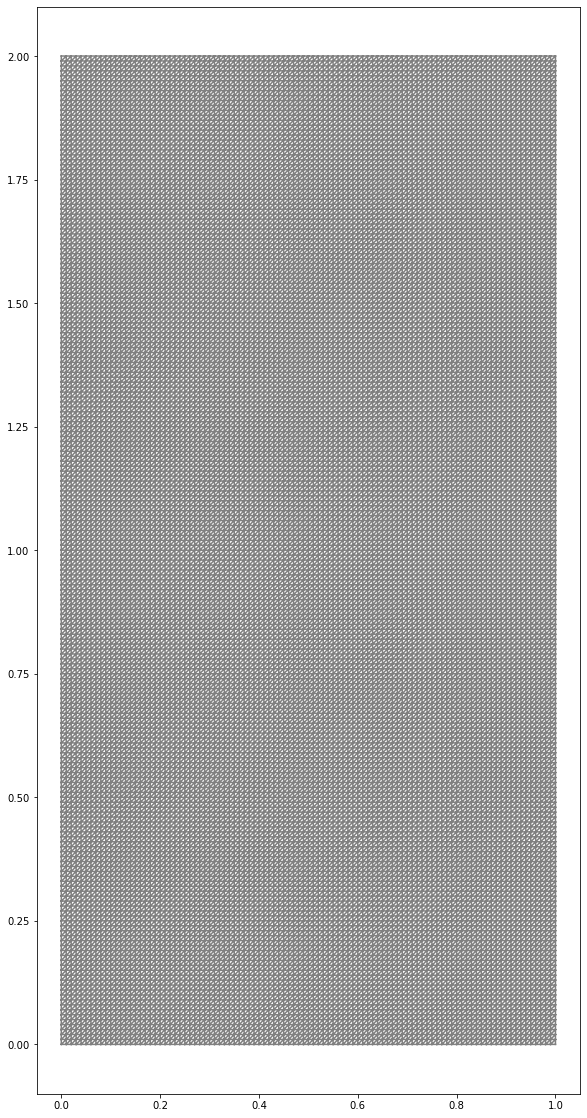

In [4]:
length = 1.0
if oscilation:
    width = 1.0
elif drop:
    width = 2.0
elif rising:
    width = 2.0
    
base = 0.0
center_x = 1.0
center_y = 0.45 #width / 2.
radius = 0.2 #width / 4.
rec_left = 1.5
rec_right = 2.5

    
channel = Rectangle(Point(0, 0), Point(length, width))
cylinder = Circle(Point(center_x, center_y), radius)
domain = channel# - cylinder


mesh = generate_mesh(domain, 128)
mesh = UnitSquareMesh(100,100)
plt.figure(figsize=(15,20))

mesh = RectangleMesh(Point(0.0, 0.0), Point(length, width), 100,100*int(width/length))
#mesh = generate_mesh(domain, 128)
plot(mesh)


In [5]:
h = mesh.hmax()
dt = 0.005#h**1.1*0.5
dτ = dt #h**1.1*0.5
ϵ = h**0.9*0.5
ρ_in = 0.1
ρ_out = 1.0

We now create the function spaces, notice the difference between the function spaces for the velocity and pressure spaces, not only on the geometrical character but also on the degree. 

In [6]:
h

0.014142135623730963

In [7]:
# Define function spaces (P2-P1)
V = VectorFunctionSpace(mesh, "Lagrange", 2)
#V = FunctionSpace(mesh, "N1curl", 2) # does not seems to work
Q = FunctionSpace(mesh, "Lagrange", 1)
W = FunctionSpace(mesh, "Lagrange", 1)

# Define trial and test functions
u = TrialFunction(V)
p = TrialFunction(Q)
ϕ = TrialFunction(W)
v = TestFunction(V)
q = TestFunction(Q)
w = TestFunction(W)

# Define functions for solutions at previous and current time steps
u_n = Function(V, name = "Velocity")
u_np  = Function(V, name = "Velocity")
p_n = Function(Q, name = "Pressure")
p_np  = Function(Q, name = "Pressure")
n = Function(V, name = "Normal")
g = Function(V, name = "gradient")
δ = Function(W, name = "δ")
p_n = Function(Q, name = "Pressure")
p_np  = Function(Q, name = "Pressure")
ϕ_n = Function(W, name = "phi")
ϕ_k = Function(W, name = "phi")
ϕ_np  = Function(W, name = "phi")

Some expressions we shall use at the variational stage

In [8]:
# Define expressions used in variational forms
U  = 0.5*(u_n + u)
f  = Constant((0, 0))
k  = Constant(dt)
mu = Constant(μ)
rho = Constant(ρ)
mu_n = Constant(μ)
rho_n = (ρ_out + ϕ_n*(ρ_in-ρ_out))
mu_np = Constant(μ)
rho_np = (ρ_out + ϕ_np*(ρ_in-ρ_out))

We define $\epsilon_{ij}(u) := \partial_{(i} v_{j)}$ and $\sigma_{ij} := 2 \mu \epsilon_{ij} - p \delta_{ij}$

In [9]:
# Define symmetric gradient
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
    return 2*mu*epsilon(u) - p*Identity(len(u))

We are now in condition to set the boundaries.

In [10]:
tol = 1.0E-4

boundary_markers = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)


#Definimos condiciones de contorno. Solo pedimos que la velocidad se anule en las superficies y ponemos
#condiciones de Neumann para la presión


class outer_top_bottom(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (near(x[1], 0.0, tol) or near(x[1], width, tol)) 

class outer_corner(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (x[0] < 0.1 and x[1] > 0.99*width) 

    
class outer_top(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (near(x[1], width, tol)) 

class outer_bottom(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (near(x[1], 0.0, tol)) 

class outer_left(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0, tol)

class outer_right(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (near(x[0], length, tol))

class inner_cyl(SubDomain):
    def inside(self, x, on_boundary):
        #return  on_boundary and near((x[0]-center_x)**2 + (x[1]-center_y)**2, radious**2, tol) 
        return on_boundary and (x[0] > center_x-radius-tol) and (x[0] < center_x+radius+tol)\
                       and (x[1] > center_y-radius-tol) and (x[1] < center_y+radius+tol)


#boundary markers
boundary_markers = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)
boundary_t = outer_top()
boundary_t.mark(boundary_markers, 0)

boundary_b = outer_bottom()
boundary_b.mark(boundary_markers, 1)

boundary_l = outer_left()
boundary_l.mark(boundary_markers, 2)

boundary_r = outer_right()
boundary_r.mark(boundary_markers, 3)

boundary_corner = outer_corner()
boundary_corner.mark(boundary_markers, 4)

boundary_cyl = inner_cyl()
boundary_cyl.mark(boundary_markers, 5)
    
    
inflow = Expression(("x[1]*(width-x[1])/(0.25*width*width)", "0"), degree=2, width = width)

inflow = Constant((0.0,0.0))

bc_u_b = DirichletBC(V, Constant((0.0,0.0)), boundary_b)
bc_u_t = DirichletBC(V, Constant((0.0,0.0)), boundary_t)
bc_u_cyl = DirichletBC(V, Constant((0,0)), boundary_cyl)
bc_u_l = DirichletBC(V, inflow, boundary_l)
bc_u_r = DirichletBC(V, inflow, boundary_r)
bc_p_t = DirichletBC(Q, Constant(0), boundary_t)

bcu = [bc_u_b, bc_u_l, bc_u_r, bc_u_t]#, bc_u_cyl]
bcp = []


ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)
#n = FacetNormal(mesh.leaf_node())
nwall = FacetNormal(mesh)

In [11]:
#Definimos ϕ

R = 1.0/6.0

x_c = 0.4923
y_c = 0.3

if oscilation:
    x_c = 0.4923
    y_c = 0.5012
elif drop:
    R = 1.0/3.0
    x_c = length/2.0
    y_c = width
    
elif rising:
    R = 1.0/6.0
    x_c = length/2
    y_c = 0.5
d = 0.1
ϵ = h**(1-d)*0.5
dτ = h**(1+d)*0.5

if oscilation:
    ϕ_0 = Expression("1.0/(1.0 + exp((sqrt(2.0*(x[0]-xc)*(x[0]-xc)+(x[1]-yc)*(x[1]-yc)) - R)/eps))", degree = 2, eps = ϵ, R = R, xc = x_c, yc = y_c)
elif drop:
    ϕ_0 = Expression("1.0/(1.0 + exp((sqrt((x[0]-xc)*(x[0]-xc)+(x[1]-yc)*(x[1]-yc)) - R)/eps))", degree = 2, eps = ϵ, R = R, xc = x_c, yc = y_c)    
elif rising:
    ϕ_0 = Expression("1.0/(1.0 + exp((sqrt((x[0]-xc)*(x[0]-xc)+(x[1]-yc)*(x[1]-yc)) - R)/eps))", degree = 2, eps = ϵ, R = R, xc = x_c, yc = y_c)    
else:
    ϕ_0 = Expression("1.0/(1.0 + exp((sqrt(1.0*(x[0]-xc)*(x[0]-xc)+(x[1]-yc)*(x[1]-yc)) - R)/eps))", degree = 2, eps = ϵ, R = R, xc = x_c, yc = y_c)

    #ϕ_0 = Expression("1.0/(1.0 + exp(((x[0]-xc-R)/eps))) * 1.0/(1.0 + exp((-(x[0]-xc+R)/eps))) * 1.0/(1.0 + exp((-(x[1]-xc+1.5*R)/eps))) * 1.0/(1.0 + exp(((x[1]-xc-1.5*R)/eps)))",degree = 2, xc = x_c, eps = ϵ, R = R)

ϕ_n.interpolate(ϕ_0)
ϕ_k.assign(ϕ_n)
ϕ_np.assign(ϕ_n)
g.assign(project(grad(ϕ_n), V))
δ.assign(project(sqrt(inner(g,g)), W))
n.assign(project(g/δ, V))


plt.figure(figsize = (10,10))
plot(ϕ_n)
plot(mesh, alpha = 0.5)

In [12]:
y_c

0.5

In [13]:
#A small initial reinitialization
k = 0
err = 1
tol = 1e-7
a_ϕ2 = ϕ*w*dx - dτ*(ϕ*(0.5-ϕ_k) - ϵ*0.5*inner(grad(ϕ),n))*inner(grad(w), n)*dx
L_ϕ2 = ϕ_k*w*dx + dτ*(0.5*ϕ_k - 0.5*ϵ*inner(grad(ϕ_k),n))*inner(grad(w), n)*dx

while (k < 60 and err > tol):
    
    ϕ_k.assign(ϕ_np)

    #solve(F_ϕ2 == 0, ϕ_np)
    solve(a_ϕ2 == L_ϕ2, ϕ_np)
    #solve(a3 == L3, ϕ)
    diff = ϕ_np-ϕ_k
    err = assemble(diff**2*dx(mesh))/dτ
    k = k+1
    
print(err, k)

8.856935418871885e-08 12


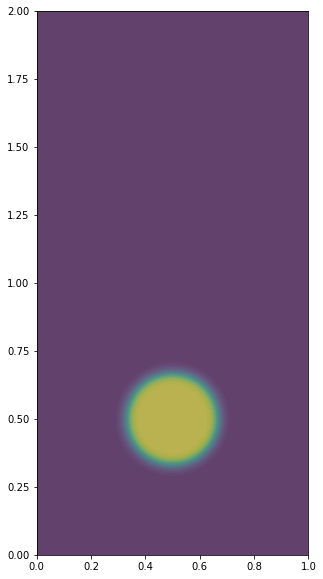

In [14]:
plt.figure(figsize = (10,10))
plot(ϕ_n)
plot(mesh, alpha = 0.5)

The first step it to solve for $u^{\star}$, a first approximation to the value of $u$ at $t+dt$:

$$ < \rho(u^{\star} - u^n)/dt, v>_{\Omega} + <\rho u^n \cdot \nabla u^n, v>_{\Omega} + <\sigma(u^{n+\frac12},p^n), \epsilon(v)>_{\Omega} + <p^n n, v>_{\partial\Omega} - <\mu \nabla(u^{n+\frac12})\cdot n, v>_{\partial\Omega} = <f^n,v>_{\Omega},
$$

where $u^{n+\frac12} := \frac12(u^n + u^{\star})$

In [15]:
# Define symmetric gradient
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
    return 2*mu_np*epsilon(u) - p*Identity(len(u))

We = 130.0

Re = 120.0

Fr = 1.0


#Velocidad tentativa

F1 = rho_np*inner(u,v)/dt*dx - rho_n*inner(u_n,v)/dt*dx \
    - rho_np*dot(dot(u_n, grad(v)),u)*dx\
    + (1.0/Re)*mu_np*inner(grad(u) + nabla_grad(u_n), grad(v))*dx\
    + (1/We)*δ*inner(((Identity(2)-outer(n,n))),grad(v))*dx\
    + p_n*inner(v,nwall)*ds\
    - p_n*div(v)*dx\
    - Fr*Fr*inner(Constant((0.0,-1.0)), v)*rho_np*dx\
    + rho_np*inner(inner(u, nwall)*nwall, v)*ds\

#- (1.0/Re)*mu_np*dot(dot(grad(u) + nabla_grad(u_n),nwall), v)*ds\
#+ rho_np*inner(u_n, nwall)*inner(u, v)*ds\
#+ inner(grad(p_n), v)*dx

a1 = lhs(F1)
L1 = rhs(F1)

#other way...
"""
F1 = dot((u*rho_np - u_n*rho_n) / dt, v)*dx \
   + rho_n*dot(dot(u_n, nabla_grad(u_n)), v)*dx \
   + inner(sigma(U, p_n), epsilon(v))*dx \
   + dot(p_n*n, v)*ds - dot(mu_np*nabla_grad(U)*n, v)*ds \
   - (1/We)*δ*inner(div((Identity(2)-outer(n,n))),v)*dx 

a1 = lhs(F1)
L1 = rhs(F1)
"""


#Recalculamos presión

# Define variational problem for step 2
a2 = dot(nabla_grad(p), nabla_grad(q))/rho_np*dt*dx
L2 = dot(nabla_grad(p_n), nabla_grad(q))/rho_np*dt*dx - div(u_np)*q*dx

F2 = div(u_np)*q/dt*dx + inner(grad(p)-grad(p_n), grad(q))/rho_np*dx

#a2 = lhs(F2)
#L2 = rhs(F2)


#Calculamos finalmente la velocidad final

# Define variational problem for step 3
a3 = dot(u, v)*dx
L3 = dot(u_np, v)*dx - k*dot(nabla_grad(p_np - p_n), v)*dx

a3 = dot(u, v)*dx
L3 = dot(u_np, v)*dx - dt*dot(grad(p_np - p_n), v)/rho_np*dx 

# Assemble matrices
A1 = assemble(a1)
A2 = assemble(a2)
A3 = assemble(a3)

# Apply boundary conditions to matrices
[bc.apply(A1) for bc in bcu]
[bc.apply(A2) for bc in bcp]
#[bc.apply(A3) for bc in bcu]

[]

We choose the solver for the matrix inversion:

In [16]:
# Use amg preconditioner if available
prec = "amg" if has_krylov_solver_preconditioner("amg") else "default"

# Use nonzero guesses - essential for CG with non-symmetric BC
parameters['krylov_solver']['nonzero_initial_guess'] = True

In [17]:
#Initial data...
#Resolvemos la ecuación de Stokes para encontrar un buen par de velocidades y presiones iniciales


# Definimos espacios de funciones
P2 = VectorElement("Lagrange", mesh.ufl_cell(), 2)
P1 = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
TH = P2*P1   #--> elementos mixtos
Wm = FunctionSpace(mesh, TH)

# Create mesh functions over the cell facets
sub_domains = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
# Mark all facets as sub domain 0
sub_domains.set_all(1)

# Define variational problem
(um, pm) = TrialFunctions(Wm)
(vm, qm) = TestFunctions(Wm)
wm = Function(Wm, name = "Flow")



#inflow = Constant((0,0))
bcu_mixed_t = DirichletBC(Wm.sub(0), Constant((0,0)), boundary_t)
bcu_mixed_b = DirichletBC(Wm.sub(0), Constant((0,0)), boundary_b)
bcu_mixed_l = DirichletBC(Wm.sub(0), Constant((0,0)), boundary_l)
bcu_mixed_r = DirichletBC(Wm.sub(0), Constant((0,0)), boundary_r) 
bcp_mixed = DirichletBC(Wm.sub(1), Constant((0.5)), boundary_b) 
# Collect boundary conditions
bcs_mixed = [bcu_mixed_t,bcu_mixed_l,bcu_mixed_r, bcu_mixed_t]

#grav = project(Constant((0.0, -2.0))* (ρ_in + ϕ_n*(ρ_in - ρ_out)), V2) 
#grav = Constant((0.0, -10.0))
#we now solve stoke's equations
g.assign(project(grad(ϕ_np), V))
δ.assign(project(sqrt(inner(g,g)), W))
n.assign(project(g/sqrt(inner(g,g)), V))

rho_n = project((ρ_out + ϕ_n*(ρ_in-ρ_out)), Q)
rho_np = project(ρ_out + ϕ_np*(ρ_in-ρ_out), Q)

amix = (inner(grad(um), grad(vm))/Re - div(vm)*pm + qm*div(um))*dx
Lmix = + Fr*Fr*inner(Constant((0.0,-1.0)), vm)*rho_np*dx -1/We*δ*(inner((Identity(2)-outer(n,n)),grad(vm)))*dx #surface tension + gravity
     
solve(amix == Lmix, wm, bcs_mixed)
u_nmix, p_nmix = wm.split()
   


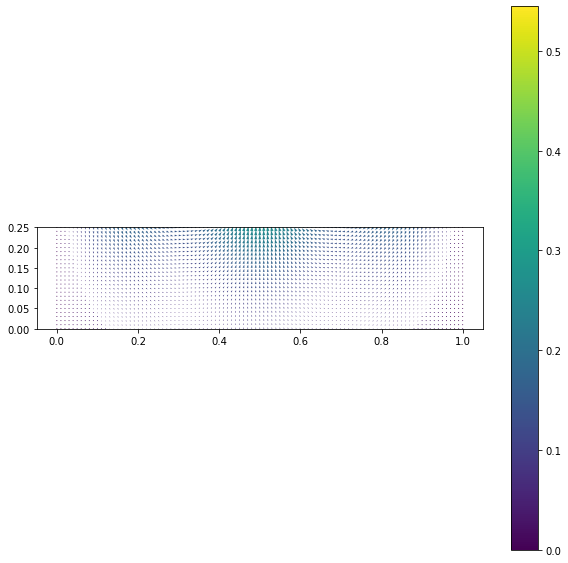

In [18]:
#plot inicial de velocidades
plt.figure(figsize = (10,10))
c = plot(u_nmix)
plt.colorbar(c)

In [19]:
#plot inicial de presiones
u_n.assign(project(u_nmix, V))
u_np.assign(u_n)
p_n.assign(project(p_nmix,Q))
p_np.assign(p_n)
c = plot(p_n)
plt.colorbar(c)

In [20]:
#Archivos para guardar datos

#ufile = File("NS_simple_bubble/velocity-rising-bubble-1-.pvd")
#pfile = File("NS_simple_bubble/pressure-rising-bubble-1-.pvd")
#phifile = File("NS_simple_bubble/phi-rising-bubble-1-.pvd")


ufile = File("NS_simple_bubble/velocity-rising-totalslip-bubble-.pvd")
pfile = File("NS_simple_bubble/pressure-rising-totalslip-bubble-.pvd")
phifile = File("NS_simple_bubble/phi-rising-totalslip-bubble-.pvd")
#vfile = File("NS_results/vorticity.pvd")
#dfile = File("NS_results/divergence.pvd")

In [21]:
num_steps = 1001
nmod = 10
import numpy as np

In [22]:
# Time-stepping


#=======ADVECCIÓN==========

t = 0
s = h*inner(u_n, grad(w))*0.5/(sqrt(inner(u_n,u_n)))   #Esto es para una estabilización SUPG que al final no hizo falta
a_ϕ1 = ϕ*w*dx - 0.5*dt*(ϕ*inner(grad(w), u_n))*dx# + ϕ*w*dx + 0.5*dt*s*inner(grad(ϕ), u_n)*dx #lo comentado es para SUPG
L_ϕ1 = ϕ_n*w*dx + 0.5*dt*(ϕ_n*inner(grad(w), u_n))*dx# + ϕ_n*w*dx - 0.5*dt*s*inner(grad(ϕ_n), u_n)*dx #lo comentado es para SUPG

#dt = dt
k = Constant(dt)

#========REINICIALIZACIÓN======

a_ϕ2 = ϕ*w*dx - dτ*(ϕ*(0.5-ϕ_k) - ϵ*0.5*inner(grad(ϕ),n))*inner(grad(w), n)*dx
L_ϕ2 = ϕ_k*w*dx + dτ*(0.5*ϕ_k - 0.5*ϵ*inner(grad(ϕ_k),n))*inner(grad(w), n)*dx

F_ϕ2 = 1/dτ*(ϕ_np-ϕ_k)*w*dx - 0.5*(ϕ_np+ϕ_k)*(1-0.5*(ϕ_np+ϕ_k))*inner(n, grad(w))*dx + 0.5*ϵ*inner(n, grad(ϕ_np+ϕ_k))*inner(n, grad(w))*dx


#initialization ended


for m in range(num_steps):
    print(t)
        # Save to file
        
    if (m%nmod==0): 
        ufile << (u_n, t)
        pfile << (p_n, t)
        phifile << (ϕ_n, t)
        print("data saved...", f" save number = {int(m/nmod)}")
    # Compute tentative velocity step
    
    # Time-stepping
    #ADVECCIÓN
    solve(a_ϕ1 == L_ϕ1, ϕ_np)  #neumann bcs
    g.assign(project(grad(ϕ_np), V))
    δ.assign(project(sqrt(inner(g,g)), W))
    n.assign(project(g/sqrt(inner(g,g)), V))
    k = 0
    err = 1.0
    tol = 1e-6
    #REINICIALIZACIÓN
    while (k < 60 and err > tol):
    
        ϕ_k.assign(ϕ_np)

        #solve(F_ϕ2 == 0, ϕ_np)
        solve(a_ϕ2 == L_ϕ2, ϕ_np)
        #solve(a3 == L3, ϕ)
        diff = ϕ_np-ϕ_k
        err = assemble(diff**2*dx(mesh))/dτ
        k = k+1
    
    print(err, k)
    
    #p_n.assign(project(ϕ_np*5.9,Q))
    rho_n = project((ρ_out + ϕ_n*(ρ_in-ρ_out)), Q)
    rho_np = project(ρ_out + ϕ_np*(ρ_in-ρ_out), Q)
    #mu_n = project((1.0 + ϕ_n*(0.01-1.0)), Q)
    #mu_np = project((1.0 + ϕ_np*(0.01-1.0)), Q)
    g.assign(project(grad(ϕ_np), V))
    δ.assign(project(sqrt(inner(g,g)), W))
    n.assign(project(g/δ, V))
    
    #========NAVIER STOKES============# 
    #(Probé otros solvers y precondicionadores además de los default sin éxito)
    solve(a1 == L1, u_np, bcu)
    solve(a2 == L2, p_np, bcp)
    solve(a3 == L3, u_np, [])
    

    # Move to next time step
    u_n.assign(u_np)
    p_n.assign(p_np)
    ϕ_n.assign(ϕ_np)
    
    # Update current time
    t = dt*m


0
data saved...  save number = 0
9.424876192428671e-07 6
0.0
8.896703341315924e-07 3
0.005
7.449049772845426e-07 4
0.01
9.871920110394963e-07 3
0.015
8.578180370383564e-07 4
0.02
8.159425982965141e-07 4
0.025
8.003331426806074e-07 4
0.03
7.938634547763419e-07 4
0.035
7.900633117653286e-07 4
0.04
7.877527843062856e-07 4
0.045
data saved...  save number = 1
7.853392142961698e-07 4
0.05
7.833598992907847e-07 4
0.055
7.809365110986611e-07 4
0.06
7.787003226709193e-07 4
0.065
7.760257975334427e-07 4
0.07
7.733876274166192e-07 4
0.075
7.703744520190431e-07 4
0.08
7.672790652634289e-07 4
0.085
7.638984533719725e-07 4
0.09
7.603478330074757e-07 4
0.095
data saved...  save number = 2
7.565966806351007e-07 4
0.1
7.526060006981483e-07 4
0.105
7.484871771776649e-07 4
0.11
7.440883856641485e-07 4
0.115
7.396271090080669e-07 4
0.12
7.348723846726702e-07 4
0.125
7.301053993057599e-07 4
0.13
7.250443346647836e-07 4
0.135
9.93214649578769e-07 3
0.14
8.403590225402814e-07 4
0.145
data saved...  save num

KeyboardInterrupt: 

ratio (128) = 0.0467492797549064 nonslip

ratio (64) = 0.34634063688463096 slip and initial velocity/pressure

ratio (128) = 0.5005675466052402 full slip 

ratio (256) = 0.531458707007449 full slip ???